# Установка зависимостей

In [3]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.4 MB/s eta 0:00:00


In [3]:
!pip install optuna

# Импорт библиотек

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import ndcg_score
from catboost import Pool, CatBoost
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import average_precision_score
import optuna

# Подготовка и проверка датасета
**EDA**
- Загрузка датасета и оценка его размеров (количество строк и столбцов)
- Проверка на наличие пропущенных значений в каждой колонке
- Описательный анализ данных, чтобы понять распределения и статистику признаков
- Визуализация данных, чтобы увидеть распределения признаков и их корреляции.
Посмотрим на распределение рангов и query_id.

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.000000,0.000000,1.000000,3.000000,3.000000,0.333333,0.000000,0.333333,0.000000,1.000000,10.000000,0.000000,9.000000,11.000000,30.000000,8.198216,22.240604,18.240926,21.439961,8.194138,0.000000,0.000000,1.000000,5.000000,7.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,4.000000,0.000000,0.000000,0.333333,1.666667,2.333333,0.222222,0.000000,0.222222,0.222222,1.555556,0.100000,0.000000,0.111111,4.822520,0.233333,0.000000,0.000000,0.000000,0.090909,0.033333,0.100000,0.000000,0.111111,0.181818,0.133333,0.033333,0.000000,0.037037,0.151515,0,0,0.000000,0.002743,0.001837,0.001728,5.183394,0.000000,1,36.563118,24.430262,0.000000,0.000000,0.000000,6.316804,1.375925,5.183394,0.000000,8.655534,19.334808,20.730882,1.727798,0.000000,2.885178,12.187706,8.143421,5.970573,0.000000,16.648505,29.059080,79.371724,0.000000,0.000000,0.000000,1.000000,1.000000,0,0.000000,0.786755,0.971298,0.946833,11.904045,0.000000,7.738967,26.350077,22.927740,-19.201910,-20.839029,-17.627562,-7.865720,-9.926361,-22.574108,-24.810069,-21.077948,-20.642055,-19.589214,-21.995388,-23.636237,-20.421283,-6.122882,-8.437561,3.000000,76.000000,0.000000,0.000000,153.000000,3866.000000,17.000000,104.000000,0.000000,0.000000,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.000000,0.333333
1,1,10,3.000000,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.004251,1.000000,557.000000,0.000000,7.000000,11.000000,575.000000,8.198216,22.240604,18.240926,21.439961,8.194138,0.000004,0.000000,4.000000,0.000000,48.000000,6.000000,0.000000,1.000000,0.000000,7.000000,31.000000,0.000000,2.000000,0.000000,33.000000,8.501341,0.000000,1.333333,0.000000,16.000000,133.555556,0.000000,0.222222,0.000000,144.666667,0.078995,0.000000,0.571429,3.445965,0.083478,0.010772,0.000000,0.142857,0.000000,0.012174,0.055655,0.000000,0.285714,0.000000,0.057391,0.026332,0.000000,0.190476,0.000000,0,0,0.000000,0.004535,0.000000,0.000438,112.486713,0.000000,1,0.000000,122.951509,4.141566,0.000000,4.695805,0.000000,4.815739,72.061386,0.000000,9.779175,0.000000,76.674007,37.495571,0.000000,7.710171,0.000000,40.983836,769.584565,0.000000,4.753632,0.000000,860.715989,1.000000,0.000000,1.000000,0.000000,1.000000,0,0.000000,0.948870,0.000000,0.792060,23.900332,0.000000,21.651734,0.000000,24.339780,-12.018080,-20.839029,-7.961910,-24.0264

Размеры датасета: (235258, 146)
Пропущенных значений нет.


,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
count,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00,235258.00
mean,0.68,14828.41,1.91,0.21,1.19,0.55,1.96,0.80,0.10,0.54,500.00,0.83,663.54,1.53,8.41,7.92,681.40,10.28,20.69,18.65,19.99,10.27,0.50,0.32,1.50,0.59,24.87,5.39,0.09,0.45,0.19,6.19,14.65,0.22,0.94,0.43,16.13,1000000.00,0.15,0.68,0.30,10.70,101.59,0.09,0.37,0.06,108.73,0.05,0.07,0.23,6.00,0.06,0.02,0.02,0.08,0.03,0.02,0.03,0.05,0.15,0.05,0.04,0.02,0.04,0.11,0.04,0.00,0.00,0.00,0.00,0.00,0.00,81.39,2.65,1.00,4.98,90.72,21.06,0.80,3.34,1.76,24.35,59.46,1.93,7.53,3.88,66.26,37.97,1.32,5.29,2.70,42.88,1810.98,6.20,18.07,4.46,1957.62,0.70,0.06,0.38,0.18,0.73,0.00,0.11,0.59,0.32,0.77,18.02,1.79,10.15,4.82,19.16,-12.29,-14.17,-12.08,-15.64,-11.83,-14.73,-17.96,-17.56,-19.48,-14.39,-12.16,-15.05,-12.07,-16.53,-11.75,2.80,43.12,110240.26,4.25,19304.24,35757.25,17.53,24.30,299.46,476.34,10466.98,0.07,0.74,11.07,0.28,0.03,0.00,22.46,9.56
std,0.83,8193.95,1.24,0.58,1.04,0.79,1.20,0.34,0.27,0.42,288.68

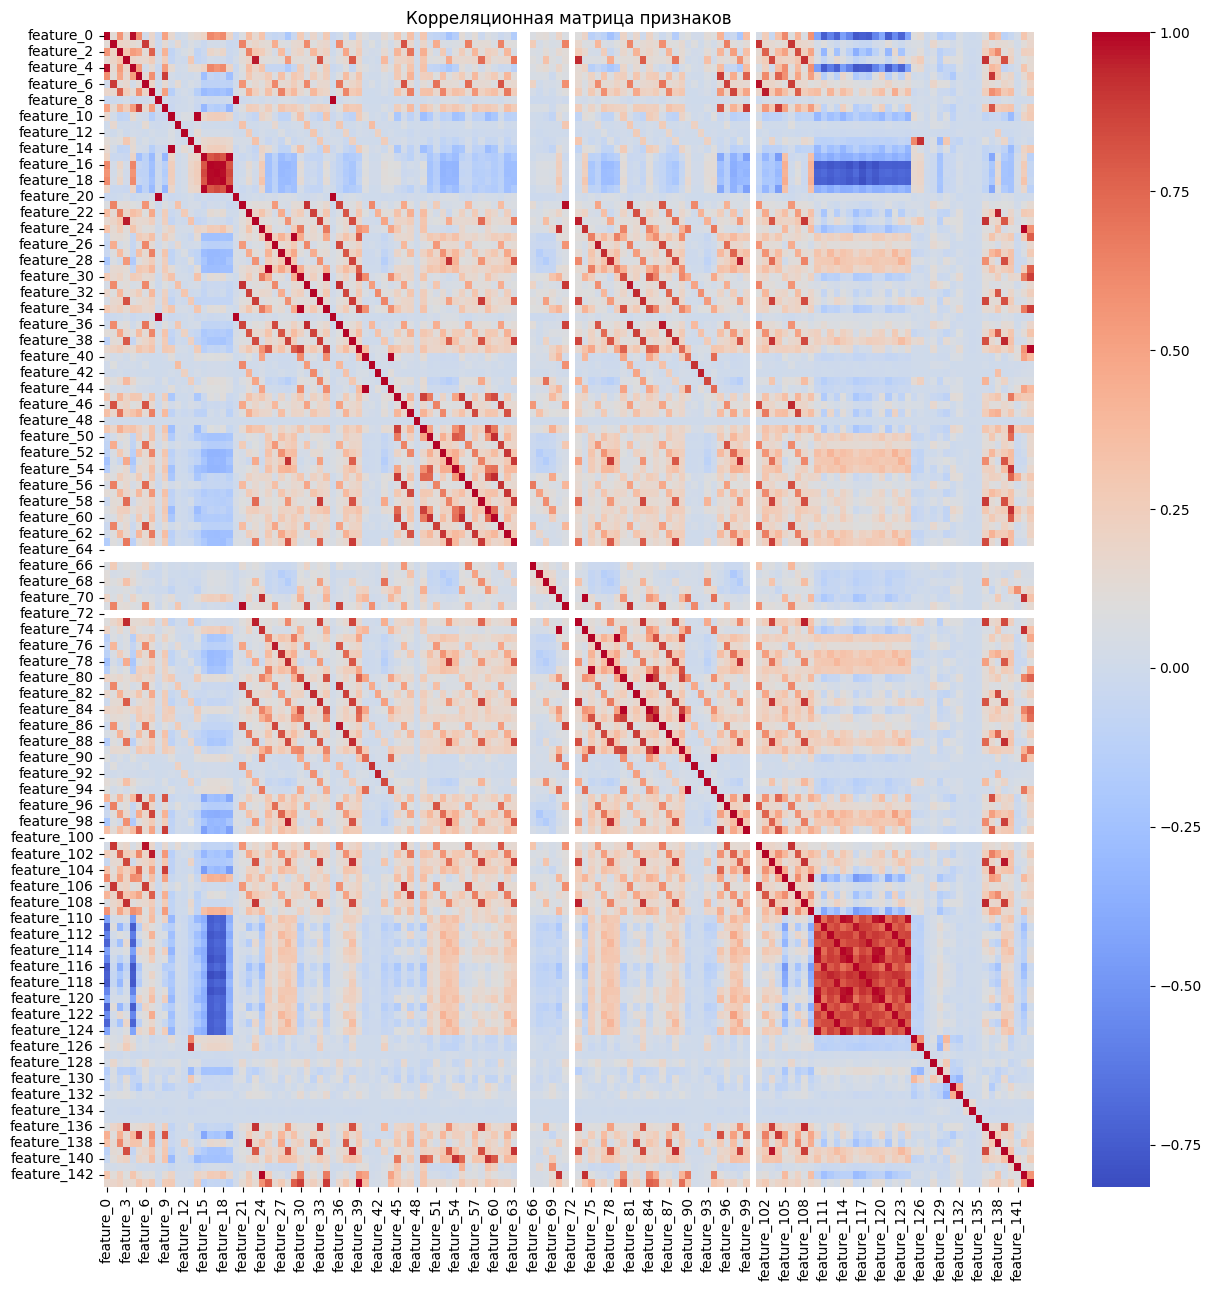

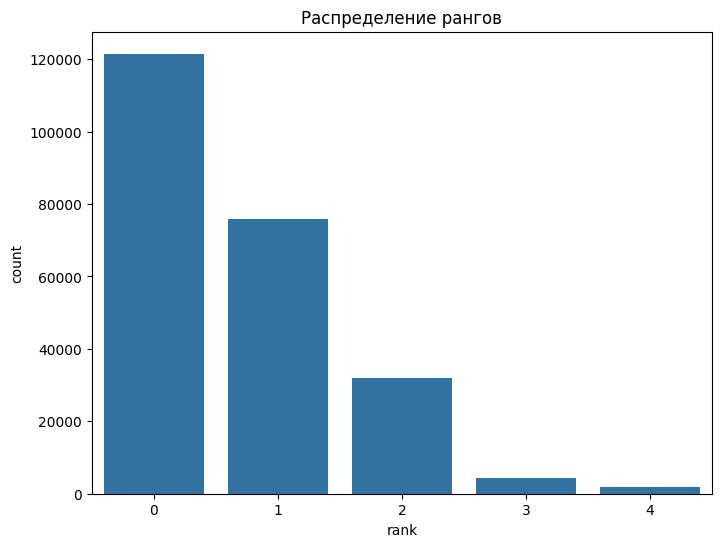

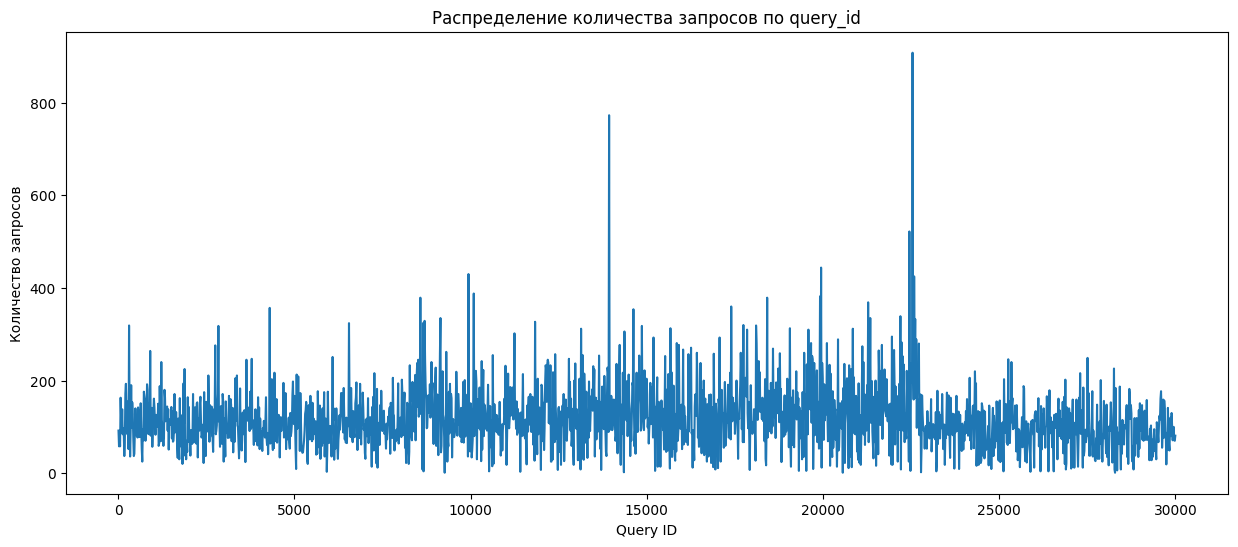

In [2]:
# Загрузка данных
data = pd.read_csv('data/intern_task.csv')
# Вывод первых 10 строк
display(data.head(10).style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '10pt')]}]
).background_gradient(cmap='coolwarm').set_caption("Первые 10 строк данных"))
# Вывод размеров датасета
print("Размеры датасета:", data.shape)
# Проверка на пропущенные значения
missing_values = data.isnull().sum()
if missing_values.any():
    display(missing_values.to_frame('Пропущенные значения').style
            .background_gradient(cmap='coolwarm')
            .set_caption("Пропущенные значения в каждой колонке"))
else:
    print("Пропущенных значений нет.")
# Описательный анализ данных
description = data.describe()
display(description.style.format("{:.2f}")
                          .background_gradient(cmap='coolwarm')
                          .set_caption("Описательная статистика данных"))
# Корреляционная матрица
plt.figure(figsize=(15, 15))
sns.heatmap(data.iloc[:, 2:].corr(), annot=False, cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()
# Распределение рангов
plt.figure(figsize=(8, 6))
sns.countplot(x='rank', data=data)
plt.title('Распределение рангов')
plt.show()
# Распределение количества запросов по query_id
query_counts = data['query_id'].value_counts()
plt.figure(figsize=(15, 6))
sns.lineplot(x=query_counts.index, y=query_counts.values)
plt.title('Распределение количества запросов по query_id')
plt.xlabel('Query ID')
plt.ylabel('Количество запросов')
plt.show()

Данные выглядят подготовленными и не требуют дополнительной обработки, перейдем к созданию модели

## Создание модели

In [3]:
# Подготовка данных
features = data.drop(['rank', 'query_id'], axis=1)
target = data['rank']
# Создаем разделение на тренировочный и тестовый наборы с учетом группировки по query_id
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(features, target, groups=data['query_id']))
X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
print("Обучающий набор:", X_train.shape, y_train.shape)
print("Тестовый набор:", X_test.shape, y_test.shape)

Обучающий набор: (188989, 144) (188989,)
Тестовый набор: (46269, 144) (46269,)


In [4]:
train_pool = Pool(data=X_train, label=y_train, group_id=data.iloc[train_idx]['query_id'])
test_pool = Pool(data=X_test, label=y_test, group_id=data.iloc[test_idx]['query_id'])

In [5]:
params = {
    'iterations': 100,
    'learning_rate': 0.01,
    'depth': 10,
    'eval_metric': 'NDCG',
    'random_seed': 42,
    'logging_level': 'Verbose',
    'loss_function': 'QuerySoftMax'
}
model = CatBoost(params)
# Обучение модели
model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    verbose=True
)

0:	test: 0.7137784	best: 0.7137784 (0)	total: 1.58s	remaining: 2m 36s
1:	test: 0.7443542	best: 0.7443542 (1)	total: 2.97s	remaining: 2m 25s
2:	test: 0.7555099	best: 0.7555099 (2)	total: 4.3s	remaining: 2m 18s
3:	test: 0.7562830	best: 0.7562830 (3)	total: 5.72s	remaining: 2m 17s
4:	test: 0.7569860	best: 0.7569860 (4)	total: 7.15s	remaining: 2m 15s
5:	test: 0.7610468	best: 0.7610468 (5)	total: 8.46s	remaining: 2m 12s
6:	test: 0.7626223	best: 0.7626223 (6)	total: 9.86s	remaining: 2m 10s
7:	test: 0.7664319	best: 0.7664319 (7)	total: 11.3s	remaining: 2m 10s
8:	test: 0.7657839	best: 0.7664319 (7)	total: 12.7s	remaining: 2m 8s
9:	test: 0.7665515	best: 0.7665515 (9)	total: 14.3s	remaining: 2m 8s
10:	test: 0.7662687	best: 0.7665515 (9)	total: 15.8s	remaining: 2m 8s
11:	test: 0.7679110	best: 0.7679110 (11)	total: 17.5s	remaining: 2m 8s
12:	test: 0.7676358	best: 0.7679110 (11)	total: 19.5s	remaining: 2m 10s
13:	test: 0.7679070	best: 0.7679110 (11)	total: 21.1s	remaining: 2m 9s
14:	test: 0.7689776

# Определение метрик и подсчёт

In [6]:
def mean_reciprocal_rank(y_true, y_pred):
    rr = 0.0
    for y_t, y_p in zip(y_true, y_pred):
        ranked_indices = [i for i, _ in sorted(enumerate(y_p), key=lambda x: x[1], reverse=True)]
        first_relevant_index = next((i for i, y in enumerate(y_t) if y), None)
        if first_relevant_index is not None:
            rr += 1.0 / (ranked_indices.index(first_relevant_index) + 1)
    return rr / len(y_true)


def mean_precision_at_k(y_true, y_pred, k):
    mpk = 0.0
    for y_t, y_p in zip(y_true, y_pred):
        ranked_indices = [i for i, _ in sorted(enumerate(y_p), key=lambda x: x[1], reverse=True)[:k]]
        relevant_indices = [i for i, y in enumerate(y_t) if y]
        precision = len(set(ranked_indices) & set(relevant_indices)) / k
        mpk += precision
    return mpk / len(y_true)

k=5

In [9]:
scores = model.predict(X_test)
ndcg_value = ndcg_score([y_test], [scores], k=5)
precision_at_k = mean_precision_at_k(y_test.values.reshape(-1,1), scores.reshape(-1,1), k=5)
mrr = mean_reciprocal_rank(y_test.values.reshape(-1,1), scores.reshape(-1,1))

print(f"NDCG@5: {ndcg_value}")
print(f"P@{k}: {precision_at_k}")
print(f"MRR: {mrr}")

NDCG@5: 0.8093745043821572
P@5: 0.09680347532901332
MRR: 0.48401737664527006


In [10]:
params = {
    'iterations': 100,
    'learning_rate': 0.01,
    'depth': 10,
    'eval_metric': 'NDCG',
    'random_seed': 42,
    'logging_level': 'Verbose',
    'loss_function': 'YetiRank'
}
model = CatBoost(params)
# Обучение модели
model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    verbose=True
)

0:	test: 0.7203777	best: 0.7203777 (0)	total: 1.12s	remaining: 1m 50s
1:	test: 0.7424825	best: 0.7424825 (1)	total: 2.36s	remaining: 1m 55s
2:	test: 0.7499924	best: 0.7499924 (2)	total: 3.58s	remaining: 1m 55s
3:	test: 0.7499625	best: 0.7499924 (2)	total: 4.77s	remaining: 1m 54s
4:	test: 0.7524150	best: 0.7524150 (4)	total: 6s	remaining: 1m 53s
5:	test: 0.7555417	best: 0.7555417 (5)	total: 7.25s	remaining: 1m 53s
6:	test: 0.7565879	best: 0.7565879 (6)	total: 8.3s	remaining: 1m 50s
7:	test: 0.7599830	best: 0.7599830 (7)	total: 9.45s	remaining: 1m 48s
8:	test: 0.7620920	best: 0.7620920 (8)	total: 10.5s	remaining: 1m 46s
9:	test: 0.7623082	best: 0.7623082 (9)	total: 11.7s	remaining: 1m 45s
10:	test: 0.7629179	best: 0.7629179 (10)	total: 13.1s	remaining: 1m 46s
11:	test: 0.7632655	best: 0.7632655 (11)	total: 14.5s	remaining: 1m 46s
12:	test: 0.7631146	best: 0.7632655 (11)	total: 15.7s	remaining: 1m 45s
13:	test: 0.7636170	best: 0.7636170 (13)	total: 17.1s	remaining: 1m 45s
14:	test: 0.7633

In [11]:
scores = model.predict(X_test)
ndcg_value = ndcg_score([y_test], [scores], k=5)
precision_at_k = mean_precision_at_k(y_test.values.reshape(-1,1), scores.reshape(-1,1), k=5)
mrr = mean_reciprocal_rank(y_test.values.reshape(-1,1), scores.reshape(-1,1))

print(f"NDCG@5: {ndcg_value}")
print(f"P@{k}: {precision_at_k}")
print(f"MRR: {mrr}")

NDCG@5: 0.9671987306219144
P@5: 0.09680347532901332
MRR: 0.48401737664527006


**Прогнав весь код - это лучший результат NDCG@5: 0.9671987306219144**

In [12]:
params = {
    'iterations': 100,
    'learning_rate': 0.01,
    'depth': 10,
    'eval_metric': 'NDCG',
    'random_seed': 42,
    'logging_level': 'Verbose',
    'loss_function': 'QueryRMSE'
}
model = CatBoost(params)
# Обучение модели
model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    verbose=True
)

0:	test: 0.7112642	best: 0.7112642 (0)	total: 796ms	remaining: 1m 18s
1:	test: 0.7372003	best: 0.7372003 (1)	total: 1.59s	remaining: 1m 17s
2:	test: 0.7535047	best: 0.7535047 (2)	total: 2.32s	remaining: 1m 14s
3:	test: 0.7596263	best: 0.7596263 (3)	total: 3.05s	remaining: 1m 13s
4:	test: 0.7615295	best: 0.7615295 (4)	total: 3.74s	remaining: 1m 11s
5:	test: 0.7621958	best: 0.7621958 (5)	total: 4.4s	remaining: 1m 8s
6:	test: 0.7633400	best: 0.7633400 (6)	total: 5.25s	remaining: 1m 9s
7:	test: 0.7642335	best: 0.7642335 (7)	total: 6.02s	remaining: 1m 9s
8:	test: 0.7640789	best: 0.7642335 (7)	total: 7.16s	remaining: 1m 12s
9:	test: 0.7640860	best: 0.7642335 (7)	total: 8.58s	remaining: 1m 17s
10:	test: 0.7659720	best: 0.7659720 (10)	total: 9.81s	remaining: 1m 19s
11:	test: 0.7673380	best: 0.7673380 (11)	total: 10.8s	remaining: 1m 19s
12:	test: 0.7665028	best: 0.7673380 (11)	total: 11.7s	remaining: 1m 18s
13:	test: 0.7665343	best: 0.7673380 (11)	total: 12.4s	remaining: 1m 16s
14:	test: 0.7687

In [13]:
scores = model.predict(X_test)
ndcg_value = ndcg_score([y_test], [scores], k=5)
precision_at_k = mean_precision_at_k(y_test.values.reshape(-1,1), scores.reshape(-1,1), k=5)
mrr = mean_reciprocal_rank(y_test.values.reshape(-1,1), scores.reshape(-1,1))

print(f"NDCG@5: {ndcg_value}")
print(f"P@{k}: {precision_at_k}")
print(f"MRR: {mrr}")

NDCG@5: 0.6079975644153728
P@5: 0.09680347532901332
MRR: 0.48401737664527006


# Определим оптимальные гиперпараметры

In [14]:
best_model = None
best_score = float('-inf')

def objective(trial):
    global best_model
    global best_score

    params = {
        'iterations': 100,
        'learning_rate': 0.01,
        'eval_metric': 'NDCG',
        'random_seed': 42,
        'logging_level': 'Verbose',
        'loss_function': 'QuerySoftMax',
        'depth': trial.suggest_int('depth', 4, 12),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50)
    }

    model = CatBoost(params)

    model.fit(
        train_pool,
        eval_set=test_pool,
        use_best_model=True,
        verbose=False
    )

    score = model.best_score_['validation']['NDCG:type=Base']

    if score > best_score:
        best_model = model
        best_score = score

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print("Best params:", best_params)
print("Best NDCG Score:", best_score)


[I 2024-04-29 20:54:27,199] A new study created in memory with name: no-name-78c9d46f-1ef9-4ed2-bcc3-9a257c0c2983


C:\Users\honor\AppData\Local\Temp\ipykernel_48720\679124795.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\honor\AppData\Local\Temp\ipykernel_48720\679124795.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
[I 2024-04-29 20:56:54,358] Trial 0 finished with value: 0.7766223016848613 and parameters: {'depth': 10, 'subsample': 0.9334678289631655, 'colsample_bylevel': 0.7175528936272422, 'min_data_in_leaf': 25}. Best is trial 0 with value: 0.7766223016848613.



bestTest = 0.7766223017
bestIteration = 95

Shrink model to first 96 iterations.


[I 2024-04-29 20:59:50,919] Trial 1 finished with value: 0.7784317518622266 and parameters: {'depth': 11, 'subsample': 0.6102967693424899, 'colsample_bylevel': 0.798175156402777, 'min_data_in_leaf': 35}. Best is trial 1 with value: 0.7784317518622266.



bestTest = 0.7784317519
bestIteration = 99



[I 2024-04-29 21:02:02,345] Trial 2 finished with value: 0.7762510607432638 and parameters: {'depth': 10, 'subsample': 0.7249980912680405, 'colsample_bylevel': 0.78548391002876, 'min_data_in_leaf': 23}. Best is trial 1 with value: 0.7784317518622266.



bestTest = 0.7762510607
bestIteration = 88

Shrink model to first 89 iterations.


[I 2024-04-29 21:03:42,656] Trial 3 finished with value: 0.7773101719531716 and parameters: {'depth': 9, 'subsample': 0.5846331061279513, 'colsample_bylevel': 0.8556782500402615, 'min_data_in_leaf': 29}. Best is trial 1 with value: 0.7784317518622266.



bestTest = 0.777310172
bestIteration = 93

Shrink model to first 94 iterations.


[I 2024-04-29 21:05:20,589] Trial 4 finished with value: 0.7765066263646722 and parameters: {'depth': 9, 'subsample': 0.6939472850614986, 'colsample_bylevel': 0.8732122732044147, 'min_data_in_leaf': 8}. Best is trial 1 with value: 0.7784317518622266.



bestTest = 0.7765066264
bestIteration = 96

Shrink model to first 97 iterations.


[I 2024-04-29 21:07:25,860] Trial 5 finished with value: 0.7777372990991448 and parameters: {'depth': 10, 'subsample': 0.9549228179549919, 'colsample_bylevel': 0.6253711778103743, 'min_data_in_leaf': 22}. Best is trial 1 with value: 0.7784317518622266.



bestTest = 0.7777372991
bestIteration = 92

Shrink model to first 93 iterations.


[I 2024-04-29 21:09:03,895] Trial 6 finished with value: 0.7760817858286273 and parameters: {'depth': 9, 'subsample': 0.65641134402016, 'colsample_bylevel': 0.9173598759687849, 'min_data_in_leaf': 37}. Best is trial 1 with value: 0.7784317518622266.



bestTest = 0.7760817858
bestIteration = 91

Shrink model to first 92 iterations.


[I 2024-04-29 21:13:37,960] Trial 7 finished with value: 0.7784160466560079 and parameters: {'depth': 12, 'subsample': 0.6068819553703941, 'colsample_bylevel': 0.9394787128487718, 'min_data_in_leaf': 26}. Best is trial 1 with value: 0.7784317518622266.



bestTest = 0.7784160467
bestIteration = 83

Shrink model to first 84 iterations.


[I 2024-04-29 21:14:47,377] Trial 8 finished with value: 0.7652517380308888 and parameters: {'depth': 5, 'subsample': 0.7889313674946306, 'colsample_bylevel': 0.8816186060160095, 'min_data_in_leaf': 35}. Best is trial 1 with value: 0.7784317518622266.



bestTest = 0.765251738
bestIteration = 89

Shrink model to first 90 iterations.


[I 2024-04-29 21:17:42,145] Trial 9 finished with value: 0.7776389370213092 and parameters: {'depth': 11, 'subsample': 0.7110320154193727, 'colsample_bylevel': 0.6048746642406657, 'min_data_in_leaf': 34}. Best is trial 1 with value: 0.7784317518622266.



bestTest = 0.777638937
bestIteration = 90

Shrink model to first 91 iterations.
Best params: {'depth': 11, 'subsample': 0.6102967693424899, 'colsample_bylevel': 0.798175156402777, 'min_data_in_leaf': 35}
Best NDCG Score: 0.7784317518622266


In [15]:
scores = best_model.predict(X_test)
ndcg_value = ndcg_score([y_test], [scores], k=5)
precision_at_k = mean_precision_at_k(y_test.values.reshape(-1,1), scores.reshape(-1,1), k=5)
mrr = mean_reciprocal_rank(y_test.values.reshape(-1,1), scores.reshape(-1,1))

print(f"NDCG@5: {ndcg_value}")
print(f"P@{k}: {precision_at_k}")
print(f"MRR: {mrr}")

NDCG@5: 0.7939028099025153
P@5: 0.09680347532901332
MRR: 0.48401737664527006
